In [1]:
import rasterio
from rasterio import features

In [2]:
import geopandas as gp
import pandas as pd
import os
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt


cwd = os.getcwd()
os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data
os.chdir(cwd)

In [3]:
tifcobveg10 = rasterio.open("../../../../../DATOS/SEGEPLAN Otros/fisico_natural-cobertura_vegetal_uso_tierra_2010 (1).tif")

In [4]:
tifcobveg10.width, tifcobveg10.height, tifcobveg10.count

(734, 768, 3)

In [5]:
bands = tifcobveg10.read()

In [6]:
tifcobveg10.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 734,
 'height': 768,
 'count': 3,
 'crs': CRS.from_wkt('LOCAL_CS["unnamed",GEOGCS["unknown",DATUM["unknown",SPHEROID["unretrievable - using WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT[,0.0174532925199433]],AUTHORITY["EPSG","-23036"],UNIT["unknown",1]]'),
 'transform': Affine(594.0868102861035, 0.0, 310286.03125,
        0.0, -593.80615234375, 1973021.375)}

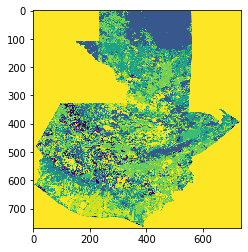

In [7]:
plt.imshow(bands[0])

In [7]:
cobveg = gp.read_file("../../../../../DATOS/SEGEPLAN Otros/cobertura_vegetal_uso_tierra_2010/cobertura_vegetal_uso_tierra_2010.shp")

In [9]:
# El shapefile obtenido de http://ideg.segeplan.gob.gt/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?3 
# tiene un CRS especial, dado por la siguiente descripción:
cobveg.crs = "+proj=tmerc +lat_0=0 +lon_0=-90.5 +k=0.9998 +x_0=500000 +y_0=0 +ellps=WGS84 +units=m +no_defs";

In [10]:
cobveg = cobveg.to_crs({'init' :'epsg:4326'})

In [8]:
cobveg.sort_values("shape_area", ascending=False).head()

,objectid,usot,shape_leng,shape_area,geometry
10,11.0,Bosque latifoliado,8.717214e+07,2.766745e+10,"MULTIPOLYGON (((-90.22555 13.84001, -90.22597 ..."
46,80.0,Vegetacion arbustiva baja (matorral y/o guamil),1.227446e+08,1.787009e+10,"MULTIPOLYGON (((-90.12952 13.74464, -90.12860 ..."
31,32.0,Granos basicos (maiz y frijol),1.020146e+08,1.217608e+10,"MULTIPOLYGON (((-90.18439 13.80417, -90.18358 ..."
62,59.0,Pasto cultivado,4.081313e+07,1.145899e+10,"MULTIPOLYGON (((-90.16213 13.75872, -90.16190 ..."
63,60.0,Pasto natural,4.484958e+07,7.011459e+09,"MULTIPOLYGON (((-90.13764 13.74761, -90.13718 ..."


In [9]:
data.munisGTshp.head()

,NOMBRE__,COD_MUNI__,DEPTO__,COD_DEPT__,PERIMETR__,AREA_KM__,geometry
0,LAGO DE AMATITLÁN,0,Guatemala,01,33.7349030215,15.2195739953,"POLYGON ((-90.57681 14.48755, -90.57627 14.487..."
1,Belice,2000,None,None,1070.02869134,21784.9579404,"POLYGON ((-88.42621 16.45034, -88.42587 16.449..."
2,Ixcán,1420,Quiché,14,296.490002139,1585.20055242,"POLYGON ((-90.50844 15.98285, -90.50905 15.982..."
3,Barillas,1326,Huehuetenango,13,147.642461182,889.649345973,"POLYGON ((-91.09267 15.80086, -91.10449 15.808..."
4,Fray Bartolomé de Las Casas,1615,Alta Verapaz,16,253.667398538,1213.66282648,"POLYGON ((-89.49999 15.84442, -89.50216 15.843..."


In [38]:
xlim = [data.munisGTshp.bounds.minx.min(), data.munisGTshp.bounds.maxx.max()]
ylim = [data.munisGTshp.bounds.miny.min(), data.munisGTshp.bounds.maxy.max()]

In [189]:
xlim, ylim

([-92.24024842288863, -88.08953205881895],
 [13.73944483114999, 18.496018441521603])

In [210]:
# Para tener un dataset más detallado que el que tiene el dataset original, vamos a multiplicar por cuatro.
width = tifcobveg10.width*4
height = tifcobveg10.height*4
resw = ((xlim[1]-xlim[0])/width)
resh= ((ylim[1]-ylim[0])/height)
transform =  rasterio.Affine.translation(xlim[0] - resw/2, ylim[0] - resh/2) * \
                rasterio.Affine.scale(resw, resh)
transform

Affine(0.0014137317316313626, 0.0, -92.24095528875445,
       0.0, 0.0015483638054595093, 13.738670649247261)

In [212]:
rasterCobVeg10 = rasterio.open("../../../../../DATOS/SEGEPLAN Otros/cobertura_vegetal_uso_tierra_2010_layers.tif", 'w+', driver = "GTiff",
                  dtype=rasterio.int8, transform=transform,
                  width=width, height=tifcobveg10.height*4, count=len(cobveg), crs='EPSG:4326')

In [214]:
rasterCobVeg10.bounds

BoundingBox(left=-92.24095528875445, bottom=18.49524425961887, right=-88.09023892468477, top=13.738670649247261)

In [216]:
i = 9
burned = features.rasterize(
    shapes=[(cobveg.iloc[i].geometry, 1)], 
    fill=0, 
    out_shape=rasterCobVeg10.shape, 
    transform=rasterCobVeg10.transform,
    all_touched=True)

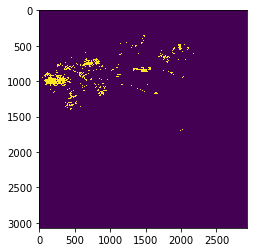

In [218]:
plt.imshow(burned)

In [224]:
# Test 0
for i, row in cobveg.iterrows():
    print(i,row)
    burned = features.rasterize(
        shapes=[(row.geometry, 1)], 
        fill=0, 
        out_shape=rasterCobVeg10.shape, 
        transform=rasterCobVeg10.transform, 
        all_touched=True)
    rasterCobVeg10.write_band(i+1, np.int8(burned))

0 objectid                                                      1
usot                                   Aeropuerto internacional
shape_leng                                              11084.9
shape_area                                          1.78247e+06
geometry      (POLYGON ((-90.91178865203513 14.2764680099489...
Name: 0, dtype: object
1 objectid                                                      2
usot                                              Agroindustria
shape_leng                                               368139
shape_area                                          2.55099e+07
geometry      (POLYGON ((-90.83540227866999 13.9812291332675...
Name: 1, dtype: object
2 objectid                                                      3
usot                                                   Aguacate
shape_leng                                               215906
shape_area                                          1.79208e+07
geometry      (POLYGON ((-90.11860495704479 13.93607

In [225]:
for i, row in cobveg.iterrows():
    rasterCobVeg10.set_band_description(i+1, str(i+1) + " - "+ row.usot)

In [226]:
rasterCobVeg10.descriptions

('1 - Aeropuerto internacional',
 '2 - Agroindustria',
 '3 - Aguacate',
 '4 - Arboles dispersos',
 '5 - Areas turisticas, arqueologicas',
 '6 - Arroz',
 '7 - Banano-Platano',
 '8 - Base militar',
 '9 - Beneficios',
 '10 - Bosque de coniferas',
 '11 - Bosque latifoliado',
 '12 - Bosque manglar',
 '13 - Bosque mixto',
 '14 - Cacao',
 '15 - Cafe',
 '16 - Cafe y banano',
 '17 - Cafe y cardamomo',
 '18 - Cafe y macadamia',
 '19 - Cana de azucar',
 '20 - Cardamomo',
 '21 - Cementerio',
 '22 - Centro comercial',
 '23 - Citricos',
 '24 - Coco',
 '25 - Complejo industrial',
 '26 - Escombreras, vertederos o rellenos sanitarios y plantas de tratamiento',
 '27 - Espacio con vegetacion escasa (tierras desnudas y degradadas)',
 '28 - Estero',
 '29 - Flores y follajes',
 '30 - Fresa',
 '31 - Frutales deciduos',
 '32 - Granos basicos (maiz y frijol)',
 '33 - Hidroelectrica',
 '34 - Rambutan',
 '35 - Rio',
 '36 - Hospital',
 '37 - Huerto',
 '38 - Hule',
 '39 - Humedal con bosque',
 '40 - Humedal con ve

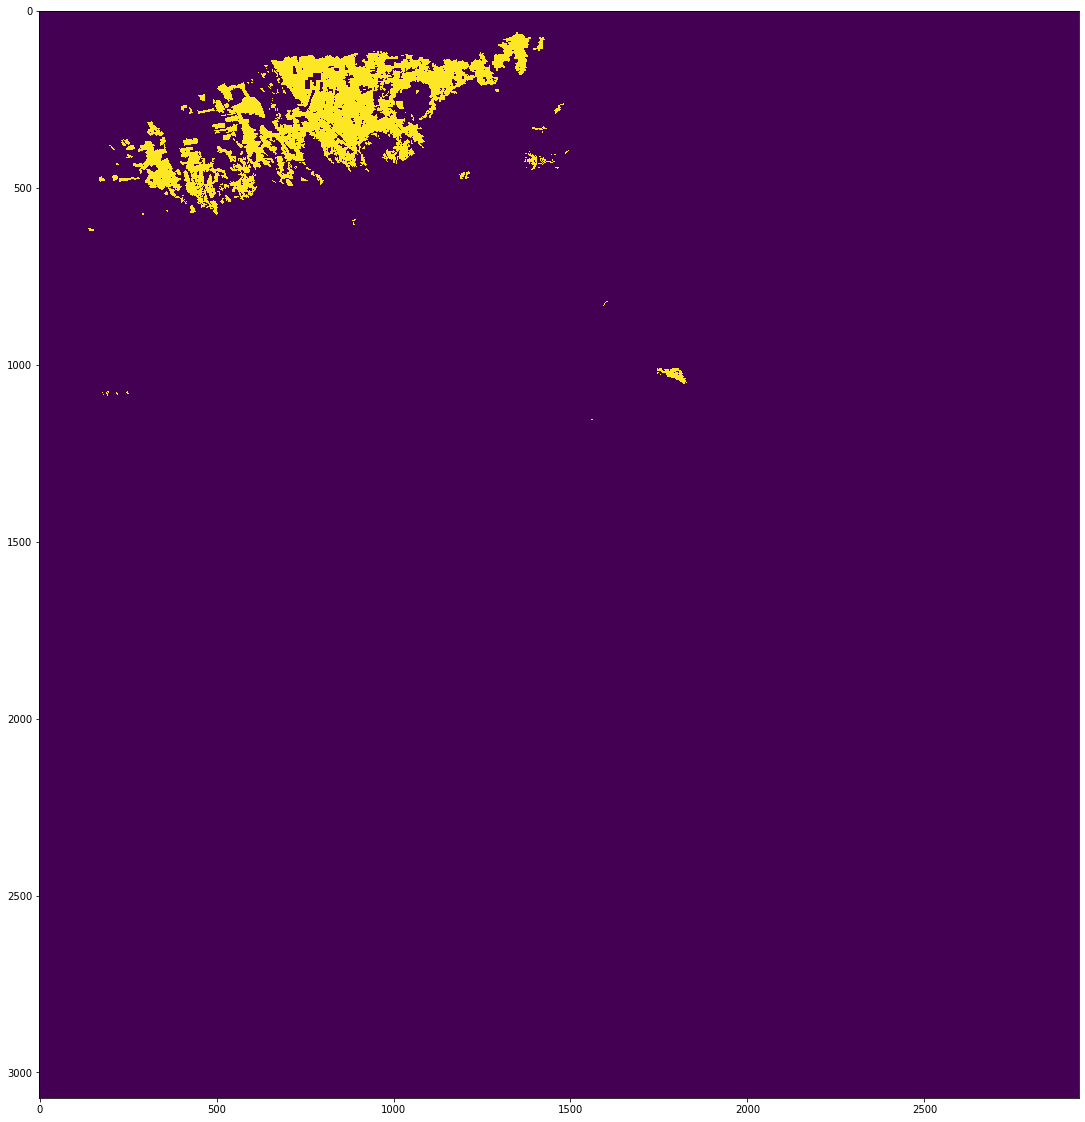

In [9]:
plt.imshow(rasterCobVeg10.read(19))

In [10]:
rasterCobVeg10.close()

In [11]:
rasterCobVeg10 = rasterio.open("../../../../../DATOS/SEGEPLAN Otros/cobertura_vegetal_uso_tierra_2010_layers.tif")

In [12]:
rasterCobVeg10.width, rasterCobVeg10.height, rasterCobVeg10.count, rasterCobVeg10.meta

(2936,
 3072,
 86,
 {'driver': 'GTiff',
  'dtype': 'int8',
  'nodata': None,
  'width': 2936,
  'height': 3072,
  'count': 86,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.0014137317316313626, 0.0, -92.24095528875445,
         0.0, 0.0015483638054595093, 13.738670649247261)})

In [13]:
d19= rasterCobVeg10.read(19)

In [14]:
rasterCobVeg10.bounds

BoundingBox(left=-92.24095528875445, bottom=18.49524425961887, right=-88.09023892468477, top=13.738670649247261)

In [15]:
data.munisGTshp[data.munisGTshp.COD_DEPT__.isna()]#.loc[(data.munisGTshp.COD_DEPT__==None)]

,NOMBRE__,COD_MUNI__,DEPTO__,COD_DEPT__,PERIMETR__,AREA_KM__,geometry
1,Belice,2000,None,None,1070.02869134,21784.9579404,"POLYGON ((-88.42621 16.45034, -88.42587 16.449..."


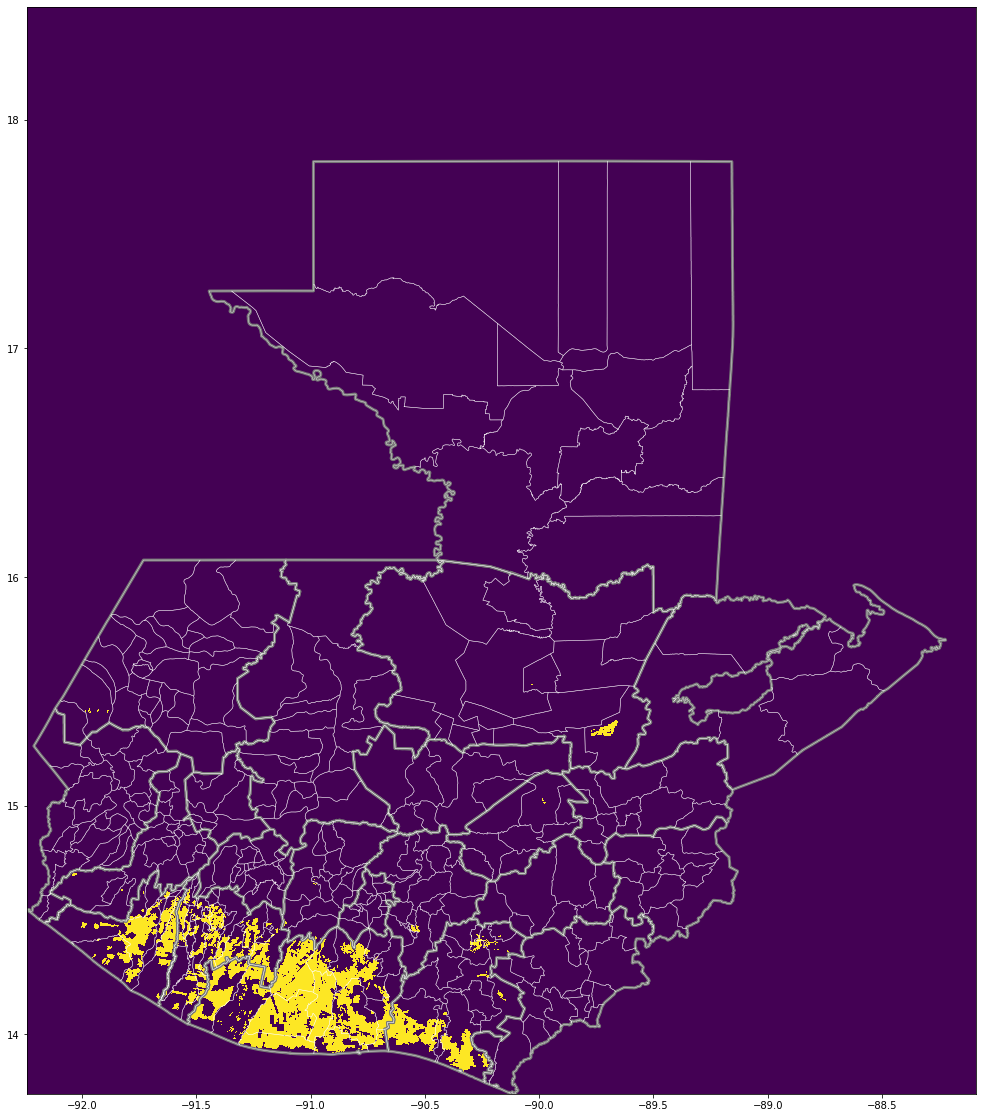

In [16]:
plt.rcParams["figure.figsize"] = (20,20)
ax = data.deptosGTshp.plot(color="#ffff0000", edgecolor="#777777", linewidth=3)
data.munisGTshp.drop(index= data.munisGTshp[data.munisGTshp.COD_DEPT__.isna()].index).plot(color="#ffff0000", edgecolor="#ffffffbb", linewidth=0.5, ax=ax)
ax.fill([-92.3,rasterCobVeg10.bounds.left,rasterCobVeg10.bounds.left, -92.3], [13.75, 13.75, 15, 15], "black")

ax.imshow(d19, extent= (rasterCobVeg10.bounds.left, rasterCobVeg10.bounds.right, rasterCobVeg10.bounds.top, rasterCobVeg10.bounds.bottom), cmap="viridis",
          origin="lower"
         )
#ax.set_ylim([13.75,15])
#ax.set_xlim([-92.3,-89.0])


In [ ]:

ax.fill()